In [1]:
!pip install "gymnasium[atari]" ale-py opencv-python imageio "imageio[ffmpeg]" opencv-python

In [7]:
!pip uninstall "gym[atari]" -y

In [8]:
import gymnasium
import ale_py

# Check if Atari is now available
print(gymnasium.envs.registry.keys()) 


dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v3', 'LunarLanderContinuous-v3', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v3', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Reacher-v5', 'Pusher-v2', 'Pusher-v4', 'Pusher-v5', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'HalfCheetah-v5', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Hopper-v5', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Swimmer-v5', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Walker2d-v5', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'Humanoid-v5

A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


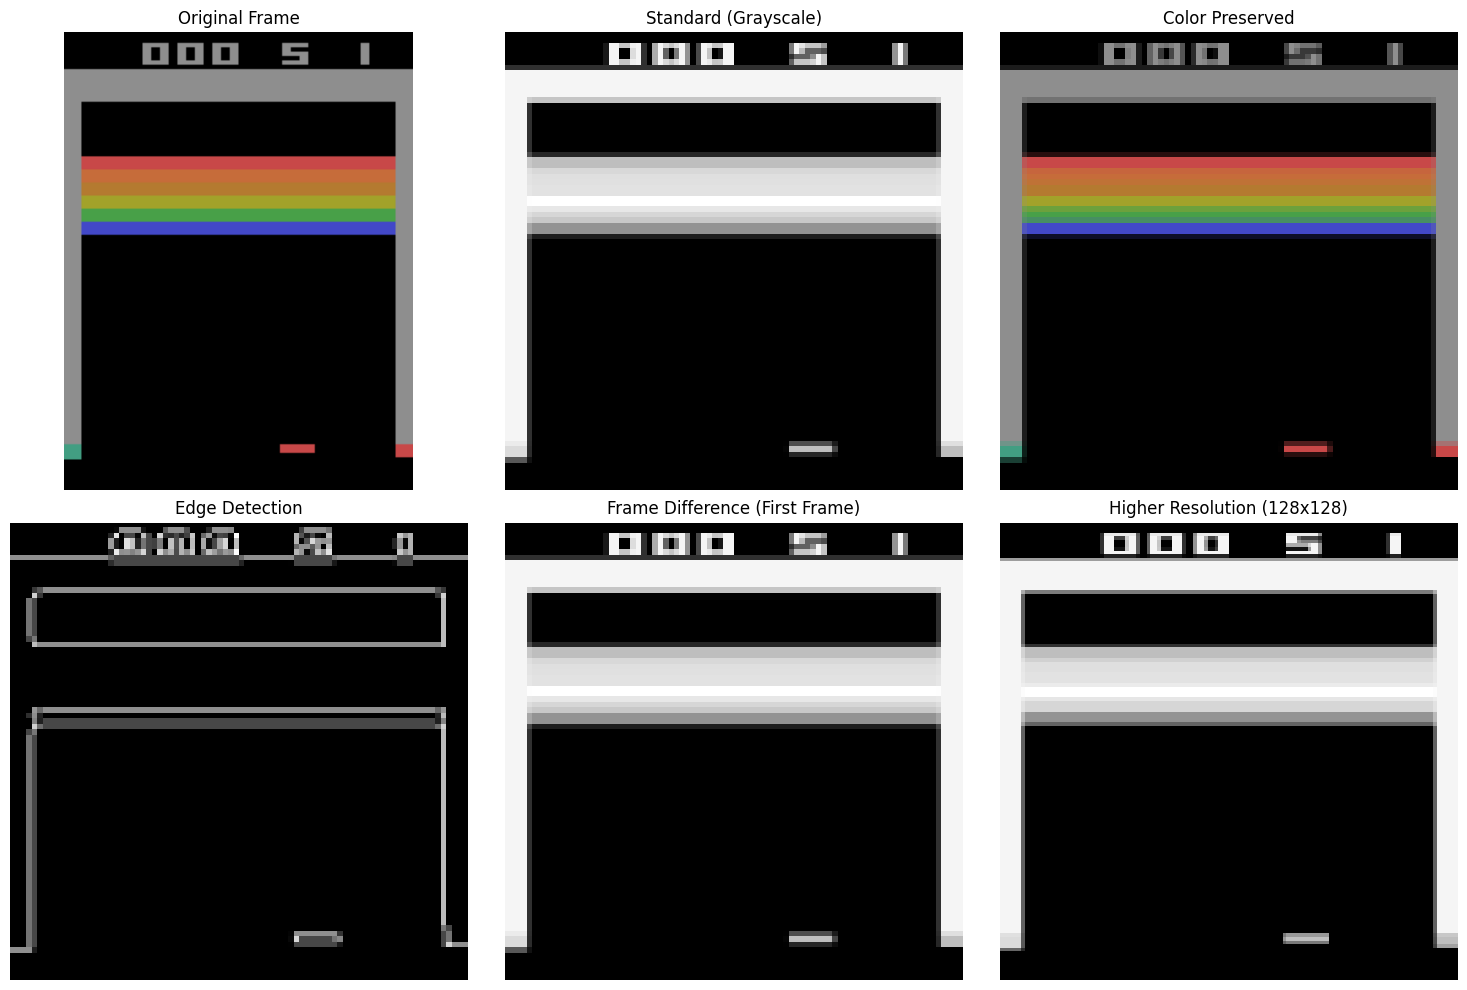

In [9]:
import numpy as np
import cv2

# Standard preprocessing function from the DQN paper
def preprocess_standard(frame):
    """
    Standard preprocessing from DQN paper:
    - Convert to grayscale
    - Resize to 84x84
    - Normalize pixel values to [0, 1]
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # Resize
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    # Normalize
    normalized = resized / 255.0
    
    return normalized


# Alternative preprocessing: Keep color information
def preprocess_color(frame):
    """
    Preprocessing that preserves color information:
    - Resize to 84x84
    - Normalize pixel values to [0, 1]
    - Return as RGB channels
    """
    # Resize
    resized = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
    # Normalize
    normalized = resized / 255.0
    # Transpose to PyTorch expected format (C, H, W)
    transposed = np.transpose(normalized, (2, 0, 1))
    
    return transposed


# Alternative preprocessing: Edge detection
def preprocess_edges(frame):
    """
    Preprocessing using edge detection:
    - Convert to grayscale
    - Apply Canny edge detection
    - Resize to 84x84
    - Normalize
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    # Resize
    resized = cv2.resize(edges, (84, 84), interpolation=cv2.INTER_AREA)
    # Normalize
    normalized = resized / 255.0
    
    return normalized


# Alternative preprocessing: Difference frame
def preprocess_difference(frame, prev_frame=None):
    """
    Preprocessing using frame differencing:
    - Convert to grayscale
    - Take difference with previous frame
    - Resize to 84x84
    - Normalize
    
    Note: This needs to be handled differently in the agent
    as it requires the previous frame.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    if prev_frame is None:
        # For the first frame, just return the grayscale
        resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
        normalized = resized / 255.0
        return normalized
    
    # Take difference with previous frame
    diff = cv2.absdiff(gray, prev_frame)
    # Resize
    resized = cv2.resize(diff, (84, 84), interpolation=cv2.INTER_AREA)
    # Normalize
    normalized = resized / 255.0
    
    return normalized


# Alternative preprocessing: Higher resolution
def preprocess_highres(frame):
    """
    Preprocessing with higher resolution:
    - Convert to grayscale
    - Resize to 128x128 instead of 84x84
    - Normalize
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # Resize to higher resolution
    resized = cv2.resize(gray, (128, 128), interpolation=cv2.INTER_AREA)
    # Normalize
    normalized = resized / 255.0
    
    return normalized


# Dictionary mapping preprocessing variant names to functions
PREPROCESSING_VARIANTS = {
    'standard': preprocess_standard,
    'color': preprocess_color,
    'edges': preprocess_edges,
    'difference': preprocess_difference,
    'highres': preprocess_highres
}


# Example of a modified agent that can use different preprocessing methods
class PreprocessingDQNAgent:
    def __init__(self, env, preprocess_func_name='standard', *args, **kwargs):
        """
        DQN Agent with customizable preprocessing
        
        Parameters:
        -----------
        env : gym.Env
            OpenAI Gym environment
        preprocess_func_name : str
            Name of preprocessing function to use
        """
        self.env = env
        
        # Set preprocessing function
        if preprocess_func_name == 'color':
            # For color, we need to adjust the input shape
            self.state_shape = (3, 84, 84)  # RGB channels
        elif preprocess_func_name == 'highres':
            # For high resolution, we need to adjust the input shape
            self.state_shape = (4, 128, 128)  # 4 frames, 128x128
        else:
            # For other methods, keep the standard shape
            self.state_shape = (4, 84, 84)  # 4 frames, 84x84
        
        # Store the preprocessing function
        self.preprocess_func = PREPROCESSING_VARIANTS[preprocess_func_name]
        
        # Store previous frame for difference preprocessing
        self.prev_frame = None
        
        # Initialize the rest of the agent
        # (rest of initialization code would go here)
    
    def preprocess_observation(self, observation):
        """
        Apply the selected preprocessing function to an observation
        """
        if self.preprocess_func.__name__ == 'preprocess_difference':
            # Handle difference preprocessing specially
            processed = self.preprocess_func(observation, self.prev_frame)
            # Update previous frame (raw grayscale, before resize)
            self.prev_frame = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        else:
            # Apply normal preprocessing
            processed = self.preprocess_func(observation)
        
        return processed
    
    # (rest of agent code would go here)


# Helper function to visualize different preprocessing methods
def visualize_preprocessing_variants(frame):
    """
    Apply and visualize different preprocessing methods on a frame
    
    Parameters:
    -----------
    frame : numpy.ndarray
        Raw RGB frame from Atari environment
    """
    import matplotlib.pyplot as plt
    
    # Create a figure to display results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Original frame
    axes[0].imshow(frame)
    axes[0].set_title('Original Frame')
    axes[0].axis('off')
    
    # Standard preprocessing
    standard = preprocess_standard(frame)
    axes[1].imshow(standard, cmap='gray')
    axes[1].set_title('Standard (Grayscale)')
    axes[1].axis('off')
    
    # Color preprocessing
    color = preprocess_color(frame)
    # Convert back from (C,H,W) to (H,W,C) for display
    color_display = np.transpose(color, (1, 2, 0))
    axes[2].imshow(color_display)
    axes[2].set_title('Color Preserved')
    axes[2].axis('off')
    
    # Edge preprocessing
    edges = preprocess_edges(frame)
    axes[3].imshow(edges, cmap='gray')
    axes[3].set_title('Edge Detection')
    axes[3].axis('off')
    
    # Difference preprocessing (assuming no previous frame)
    diff = preprocess_difference(frame)
    axes[4].imshow(diff, cmap='gray')
    axes[4].set_title('Frame Difference (First Frame)')
    axes[4].axis('off')
    
    # High-res preprocessing
    highres = preprocess_highres(frame)
    axes[5].imshow(highres, cmap='gray')
    axes[5].set_title('Higher Resolution (128x128)')
    axes[5].axis('off')
    
    plt.tight_layout()
    plt.savefig('preprocessing_comparison.png')
    plt.show()



# Sample code to demonstrate preprocessing visualization
import gymnasium as gym

# Create environment
env = gym.make('ALE/Breakout-v5')

# Get a sample frame
observation, _ = env.reset()

# Visualize different preprocessing methods
visualize_preprocessing_variants(observation)

env.close()

In [ ]:
import gymnasium as gym
import cv2
import imageio
import numpy as np
from IPython.display import display, Video

# Create the environment
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")

obs, info = env.reset()

# List to store frames
frames = []

# Define new height (must be divisible by 16)
new_height = 224  # Closest multiple of 16 above 210
new_width = 160    # Already a multiple of 16, so no change needed

# Run the agent and save frames
for _ in range(500):  # Adjust frames to control video length
    action = env.action_space.sample()  # Random action
    obs, reward, terminated, truncated, info = env.step(action)

    # Resize frame to (160, 224) to avoid codec issues
    obs_resized = cv2.resize(obs, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    frames.append(obs_resized)  # Save resized frame

    if terminated or truncated:
        obs, info = env.reset()  # Reset if game over

env.close()

# Convert frames to video
video_path = "/content/atari_gameplay.mp4"
imageio.mimsave(video_path, frames, fps=30)  # Save as MP4

# Display video in Colab
display(Video(video_path, embed=True))
